## Part 1: Import Data and Drop Meaningless Columns

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
powerlifting = pd.read_csv('./usapl_ipf.csv')

/opt/conda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (11,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
# drop meaningless columns
powerlifting.drop(['index', 'Unnamed: 0'], axis = 1, inplace=True)

## Part 1a: Drop Rows Missing information

In [33]:
# drop lifters who have no data for any lifts
useless_mask = (powerlifting['BestSquatKg'].isnull()) & (powerlifting['Squat1Kg'].isnull()) & \
(powerlifting['Squat2Kg'].isnull()) & (powerlifting['Squat3Kg'].isnull()) &\
(powerlifting['BestDeadliftKg'].isnull()) & (powerlifting['Deadlift1Kg'].isnull()) & \
(powerlifting['Deadlift2Kg'].isnull()) & (powerlifting['Deadlift3Kg'].isnull()) &\
(powerlifting['BestBenchKg'].isnull()) & (powerlifting['Bench1Kg'].isnull()) & \
(powerlifting['Bench2Kg'].isnull()) & (powerlifting['Bench3Kg'].isnull())


In [34]:
powerlifting = powerlifting[~useless_mask]

In [35]:
# drop rows where there is no weight class or bodyweight information
weight_mask = (powerlifting['WeightClassKg'].isnull()) & (powerlifting['BodyweightKg'].isnull())
powerlifting = powerlifting[~weight_mask]

## Part 2: Populate Bodyweight Column with Weight Class Information 
(Where Weight Class Has an Upper Limit)

In [36]:
powerlifting['BodyweightKg'].count()

69455

In [37]:
# mask where we have no Bodyweight information and the weight class has a lower limit. ie: '120+
# we cannot approximate a weight here since the weight can be anything over that limit, 
# whereas other weight classes have upper limits
search_upper_limit = ((powerlifting['WeightClassKg']=='120+') | (powerlifting['WeightClassKg']=='84+') | \
(powerlifting['WeightClassKg']=='140+') | (powerlifting['WeightClassKg']=='110+') | (powerlifting['WeightClassKg']=='125+') | \
(powerlifting['WeightClassKg']=='145+')| (powerlifting['WeightClassKg']=='90+')) & (powerlifting['BodyweightKg'].isnull())

In [38]:
powerlifting = powerlifting[~search_upper_limit]

In [39]:
# function to fill bodyweight with weight class where null (a good approximation)
def fill_bodyweight(row):
    if np.isnan(row['BodyweightKg']):
        row['BodyweightKg'] = pd.to_numeric(row['WeightClassKg'])
    return row
powerlifting = powerlifting.apply(fill_bodyweight, axis = 1)

## Part 3: Populate Age Column

In [40]:
# convert Date column to datetime:
powerlifting['Date'] = pd.to_datetime(powerlifting['Date'])

In [41]:
# extract year of competition:
powerlifting['Year'] = powerlifting['Date'].dt.year

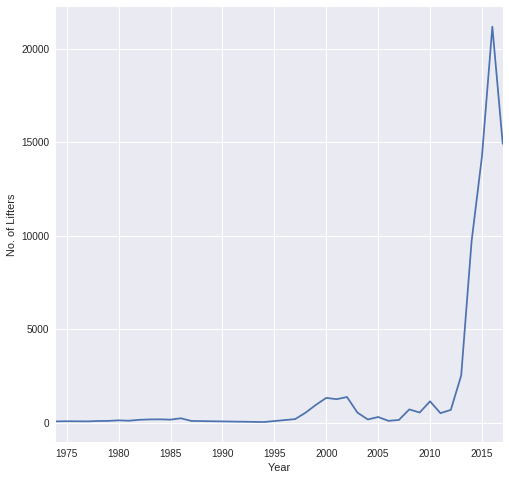

In [50]:
# graph of no. of lifters per year
plt.figure(figsize=(8, 8))
powerlifting.groupby('Year').count()['Sex'].plot()
plt.ylabel('No. of Lifters')
plt.show()

In [43]:
# function to calculate age if null
def calculate_age(row):
    if np.isnan(row['Age']) and np.isnan(row['BirthYear']) == False:
        row['Age'] = row['Year'] - row['BirthYear']
    return row 

powerlifting = powerlifting.apply(calculate_age, axis = 1)

## Part 4: Populate and Clean "Best"/"Total" Columns

In [53]:
powerlifting[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']].describe()

,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg
count,63799.000000,71413.000000,66897.000000,71695.000000
mean,170.303968,112.491702,191.379740,432.617230
std,66.023756,50.388674,61.139108,189.037466
min,-262.500000,-290.300000,-238.100000,17.500000
25%,117.500000,70.000000,142.500000,285.000000
50%,167.500000,110.000000,192.500000,430.000000
75%,212.500000,145.000000,235.000000,570.000000
max,505.000000,410.000000,420.000000,1272.500000


<p>as we can see, there are negative values for the "Best" lift columns, this means the lifter missed all three attempts at their lift. In powerlifting, three missed attempts means the lifter *"bombs out"* of the meet. We don't want these instances counting toward the BestLift column, so we need to change these to nulls. 

<p>also, there are totals within the TotalKg that were calculated off of one lift. (i.e. "Bench Only") these totals will on average be lower than the totals for 3 lifts. We want to treat this column like it only applies to people who have completed all three lifts.

In [62]:
powerlifting[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74629 entries, 0 to 75709
Data columns (total 4 columns):
BestSquatKg       63799 non-null float64
BestBenchKg       71413 non-null float64
BestDeadliftKg    66897 non-null float64
TotalKg           71695 non-null float64
dtypes: float64(4)
memory usage: 2.8 MB


In [66]:
# function to fill in negative best lifts with null values
def fix_best_lift(row):
    if row['BestSquatKg'] < 0:
        row['BestSquatKg'] = np.nan
    if row['BestBenchKg'] < 0:
        row['BestBenchKg'] = np.nan
    if row['BestDeadliftKg'] < 0:
        row['BestDeadliftKg'] = np.nan
    return row

In [63]:
powerlifting = powerlifting.apply(fix_best_lift, axis = 1)

In [71]:
# function to only calculate totals for lifters who have completed all three lifts
def fix_total(row):
    if np.isnan(row['BestSquatKg']) or np.isnan(row['BestBenchKg']) or np.isnan(row['BestDeadliftKg']):
        row['TotalKg'] = np.nan
    return row

In [72]:
powerlifting = powerlifting.apply(fix_total, axis = 1)

In [73]:
# check
powerlifting[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74629 entries, 0 to 75709
Data columns (total 4 columns):
BestSquatKg       63788 non-null float64
BestBenchKg       71402 non-null float64
BestDeadliftKg    66892 non-null float64
TotalKg           61950 non-null float64
dtypes: float64(4)
memory usage: 2.8 MB


In [74]:
powerlifting[['BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg']].describe()

,BestSquatKg,BestBenchKg,BestDeadliftKg,TotalKg
count,63788.000000,71402.000000,66892.000000,61950.000000
mean,170.360145,112.531323,191.406797,471.694686
std,65.886994,50.282754,61.059244,169.399009
min,13.600000,6.800000,15.900000,38.600000
25%,117.500000,70.000000,142.500000,330.000000
50%,167.500000,110.000000,192.500000,470.000000
75%,212.500000,145.000000,235.000000,587.500000
max,505.000000,410.000000,420.000000,1272.500000


now our stats seem more accurate. the minimum values are still pretty low, the next step is to fix this by eliminating all teen and youth competitors (they cannot lift as much due to undeveloped bodies) 

In [89]:
powerlifting[powerlifting['Age'] > 17].min()

Age                 18.000
Bench1Kg          -390.000
Bench2Kg          -453.600
Bench3Kg          -453.600
Bench4Kg          -248.000
BestBenchKg          9.100
BestDeadliftKg      18.100
BestSquatKg         13.600
BirthYear         1927.000
BodyweightKg        35.300
Deadlift1Kg       -365.000
Deadlift2Kg       -377.500
Deadlift3Kg       -400.000
Deadlift4Kg        170.000
Squat1Kg          -475.000
Squat2Kg          -475.000
Squat3Kg         -9300.000
Squat4Kg               NaN
TotalKg             40.800
Wilks               40.655
Year              1982.000
dtype: float64

In [98]:
powerlifting[powerlifting['Age'] < 17].min()

Age                  8.000
Bench1Kg          -180.000
Bench2Kg          -222.500
Bench3Kg          -222.500
Bench4Kg               NaN
BestBenchKg          9.100
BestDeadliftKg      15.900
BestSquatKg         13.600
BirthYear         1982.000
BodyweightKg        25.900
Deadlift1Kg       -245.000
Deadlift2Kg       -302.500
Deadlift3Kg       -302.500
Deadlift4Kg            NaN
Squat1Kg          -272.500
Squat2Kg          -320.000
Squat3Kg          -307.500
Squat4Kg               NaN
TotalKg             38.600
Wilks               31.445
Year              1998.000
dtype: float64

In [114]:
powerlifting[powerlifting['Age'].isnull()].min()

Age                   NaN
Bench1Kg          -377.50
Bench2Kg          -392.50
Bench3Kg          -408.50
Bench4Kg            57.50
BestBenchKg         10.00
BestDeadliftKg      20.00
BestSquatKg         15.00
BirthYear             NaN
BodyweightKg        23.90
Deadlift1Kg       -365.00
Deadlift2Kg       -382.50
Deadlift3Kg       -410.00
Deadlift4Kg        315.00
Squat1Kg          -390.00
Squat2Kg          -475.00
Squat3Kg          -475.00
Squat4Kg           222.50
TotalKg             54.40
Wilks               64.21
Year              1974.00
dtype: float64

**actually** it doesnt make much of a difference. the minimum lifts for both are very similar. (we only have age for a very small subset so its hard to determine)

In [102]:
print (powerlifting[powerlifting['Age'] < 17].shape)
print (powerlifting[powerlifting['Age'] > 17].shape)
print (powerlifting[powerlifting['Age'].isnull()].shape)

(1499, 38)
(25432, 38)
(46539, 38)


In [108]:
powerlifting[powerlifting['BestBenchKg'] == 9.100]
# SO == special olympians

,Age,Bench1Kg,Bench2Kg,Bench3Kg,Bench4Kg,BestBenchKg,BestDeadliftKg,BestSquatKg,BirthYear,BodyweightKg,...,Squat1Kg,Squat2Kg,Squat3Kg,Squat4Kg,State,Team,TotalKg,WeightClassKg,Wilks,Year
56553,19.0,-6.8,6.8,9.1,NaN,9.1,18.1,13.6,1998.0,53.97,...,-11.3,11.3,13.6,NaN,LA,NaN,40.8,57,NaN,2017
56603,12.0,-6.8,6.8,9.1,NaN,9.1,15.9,13.6,2005.0,72.30,...,9.1,11.3,13.6,NaN,LA,NaN,38.6,74,NaN,2017


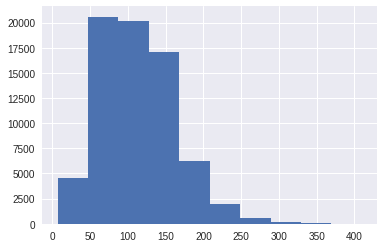

In [121]:
powerlifting['BestBenchKg'].hist()
plt.show()

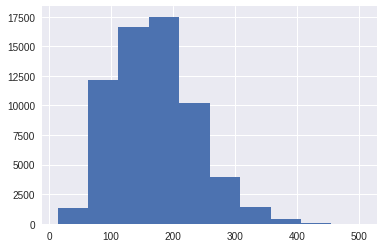

In [124]:
powerlifting['BestSquatKg'].hist()

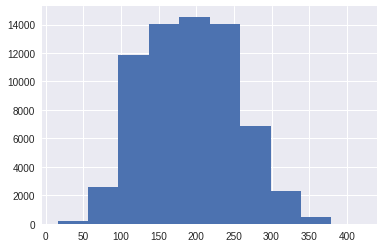

In [125]:
powerlifting['BestDeadliftKg'].hist()

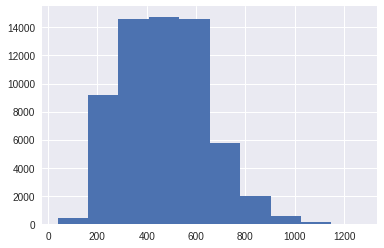

In [126]:
powerlifting['TotalKg'].hist()

In [127]:
def display_outliers(dataframe, col):
    Q1 = np.percentile(dataframe[col], 25)
    Q3 = np.percentile(dataframe[col], 75)
    tukey_window = 1.5*(Q3-Q1)
    less_than_Q1 = dataframe[col] < Q1 - tukey_window
    greater_than_Q3 = dataframe[col] > Q3 + tukey_window
    tukey_mask = (less_than_Q1 | greater_than_Q3)
    return dataframe[tukey_mask]

In [131]:
np.percentile(powerlifting[powerlifting['BestSquatKg'].isnull()==False].values, 25)

TypeError: unorderable types: float() > str()